# Create a synthetic dataset with signal

- The train dataset does not seem to contain any signal
- See [The target is just noise?](https://www.kaggle.com/competitions/playground-series-s5e2/discussion/560669)
- Until this is fixed I am creating a new synthetic dataset using a manual aprroach (LLM + Multivariate analysis). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [2]:
file_path = "/kaggle/input/playground-series-s5e2/train.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


(None,
    id         Brand Material    Size  Compartments Laptop Compartment  \
 0   0      Jansport  Leather  Medium           7.0                Yes   
 1   1      Jansport   Canvas   Small          10.0                Yes   
 2   2  Under Armour  Leather   Small           2.0                Yes   
 3   3          Nike    Nylon   Small           8.0                Yes   
 4   4        Adidas   Canvas  Medium           1.0                Yes   
 
   Waterproof      Style  Color  Weight Capacity (kg)      Price  
 0         No       Tote  Black             11.611723  112.15875  
 1        Yes  Messenger  Green             27.078537   68.88056  
 2         No  Messenger    Red             16.643760   39.17320  
 3         No  Messenger  Green             12.937220   80.60793  
 4        Yes  Messenger  Green             17.749338   86.02312  )

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)

# Assume 'df' is already loaded and has the following columns:
# 'id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
# 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'

# Define a base price for all backpacks.
base_price = 50

# --- Compute Premium Adjustments ---

# 1. Material Premium: Leather bags should be clearly more expensive;
#    Nylon bags are a bit cheaper.
df['Material_Adjustment'] = df['Material'].apply(
    lambda x: 50 if str(x).strip().lower() == 'leather'
    else (-10 if str(x).strip().lower() == 'nylon' else 0)
)

# 2. Size Premium: Large bags > Medium bags > Small bags.
df['Size_Adjustment'] = df['Size'].apply(
    lambda x: 40 if str(x).strip().lower() == 'large'
    else (20 if str(x).strip().lower() == 'medium'
          else (0 if str(x).strip().lower() == 'small' else 0))
)

# 3. Laptop Compartment Premium: Backpacks with a laptop compartment should be clearly more expensive.
df['Laptop_Adjustment'] = df['Laptop Compartment'].apply(
    lambda x: 30 if str(x).strip().lower() == 'yes' else 0
)

# 4. Waterproof Premium: Waterproof bags should be clearly more expensive.
df['Waterproof_Adjustment'] = df['Waterproof'].apply(
    lambda x: 30 if str(x).strip().lower() == 'yes' else 0
)

# 5. Color Premium: Blue and Pink backpacks get a small premium.
df['Color_Adjustment'] = df['Color'].apply(
    lambda x: 10 if str(x).strip().lower() in ['blue', 'pink'] else 0
)

# --- Combine Premiums to Compute the New Price ---
# Adding a bit of random noise (with standard deviation of 5) to simulate variation.
df['Price'] = (base_price +
               df['Material_Adjustment'] +
               df['Size_Adjustment'] +
               df['Laptop_Adjustment'] +
               df['Waterproof_Adjustment'] +
               df['Color_Adjustment'] +
               np.random.normal(scale=5, size=len(df))
              )

# Ensure that no price is negative.
df['Price'] = df['Price'].clip(lower=0)

# --- Remove the Intermediate Adjustment Columns ---
df.drop(columns=['Material_Adjustment', 'Size_Adjustment', 'Laptop_Adjustment',
                 'Waterproof_Adjustment', 'Color_Adjustment'], inplace=True)

# --- Split the Data into Train and Test Sets (80-20 split) ---
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
train_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
254099,254099,Nike,Leather,Medium,1.0,Yes,No,Backpack,Gray,27.294880,155.384628
53461,53461,Puma,NaN,Large,9.0,Yes,Yes,Messenger,Blue,8.574545,162.246230
247984,247984,Adidas,Canvas,Medium,8.0,Yes,No,Messenger,Black,11.502436,104.316043
209067,209067,Under Armour,Polyester,Medium,3.0,No,No,Backpack,Black,9.433317,69.857043
185997,185997,Puma,Nylon,Small,8.0,No,Yes,Backpack,Black,8.971236,77.047670


In [5]:
test_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
4941,4941,Jansport,Leather,Large,2.0,Yes,Yes,Tote,Blue,26.856190,208.971861
51775,51775,Puma,Canvas,Medium,3.0,No,No,Messenger,Pink,15.068683,92.330572
115253,115253,Jansport,Canvas,Small,2.0,Yes,No,Tote,Red,22.936807,84.901156
299321,299321,Under Armour,Polyester,Large,7.0,No,No,Messenger,Blue,11.917135,100.415763
173570,173570,Puma,Leather,Small,7.0,No,No,Tote,Gray,18.352518,108.288147


## Univariate analysis

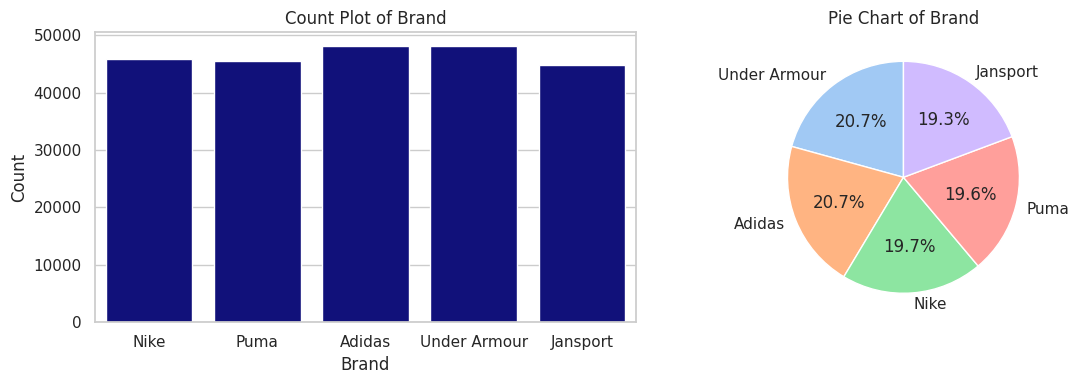

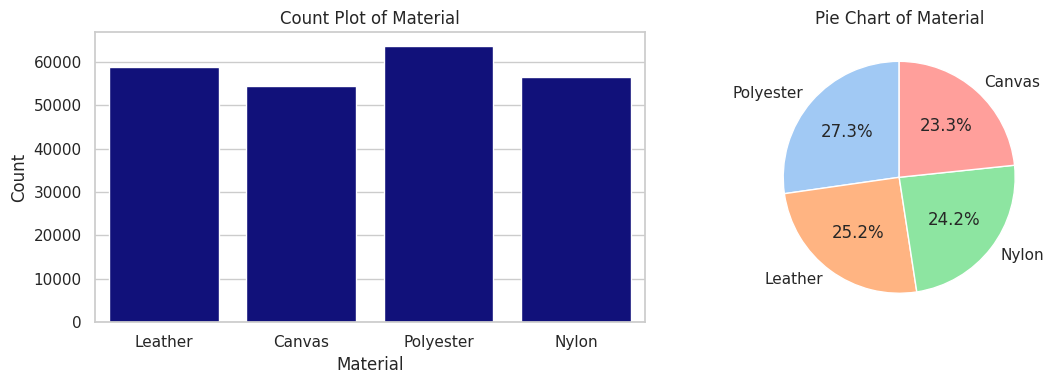

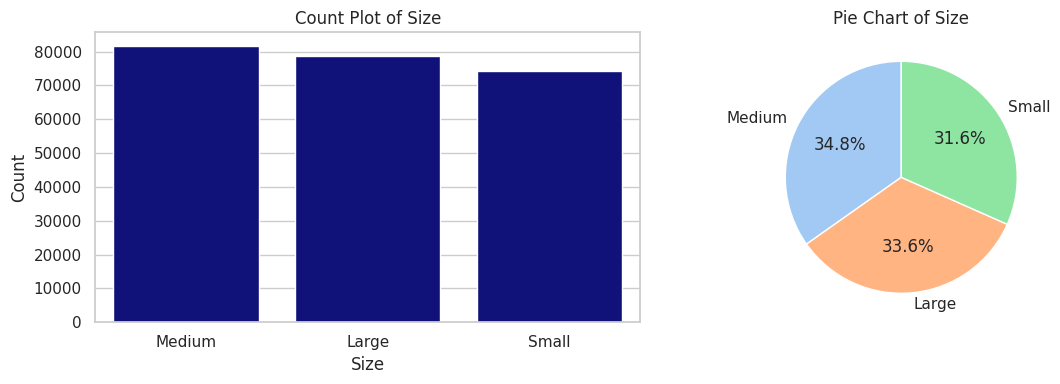

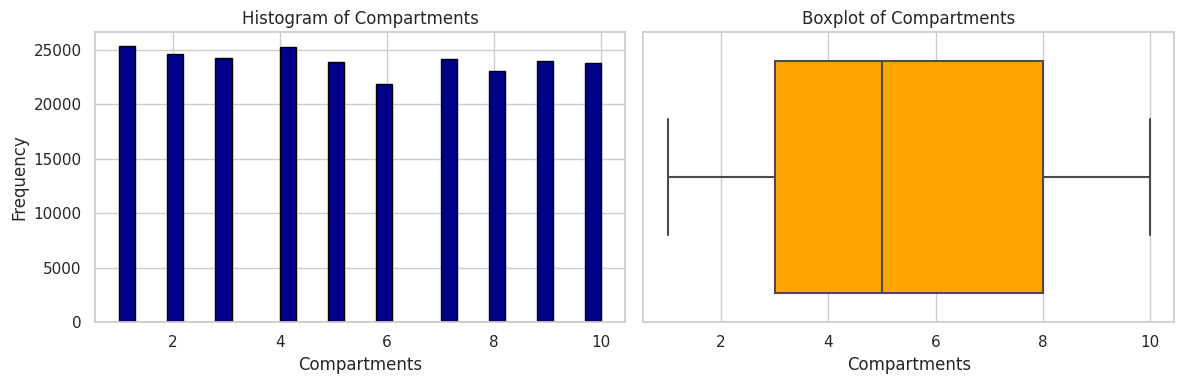

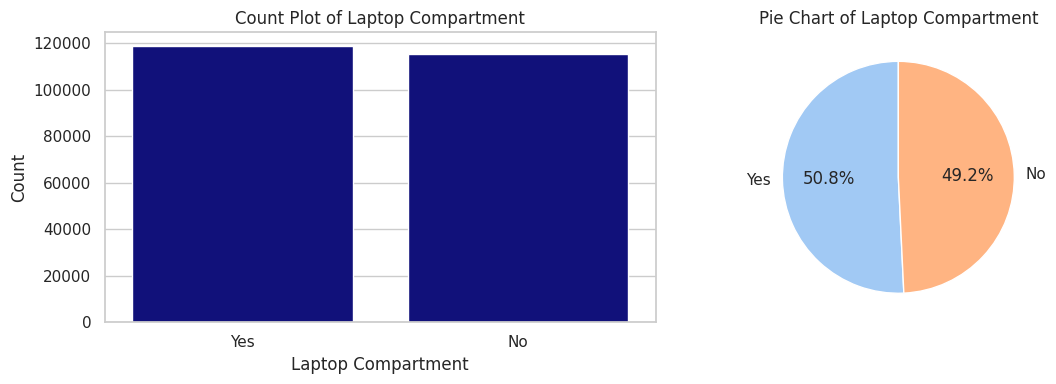

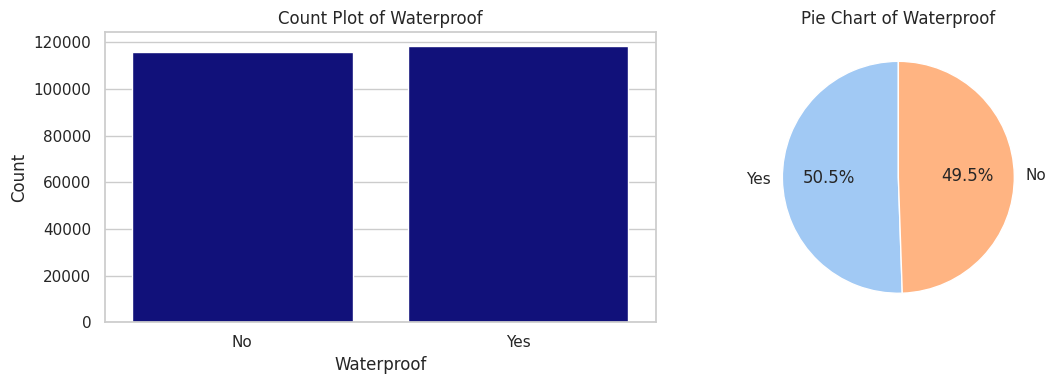

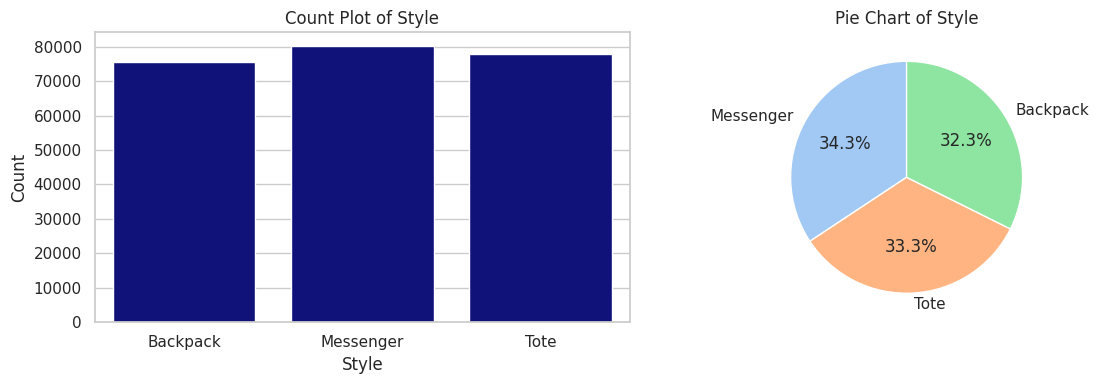

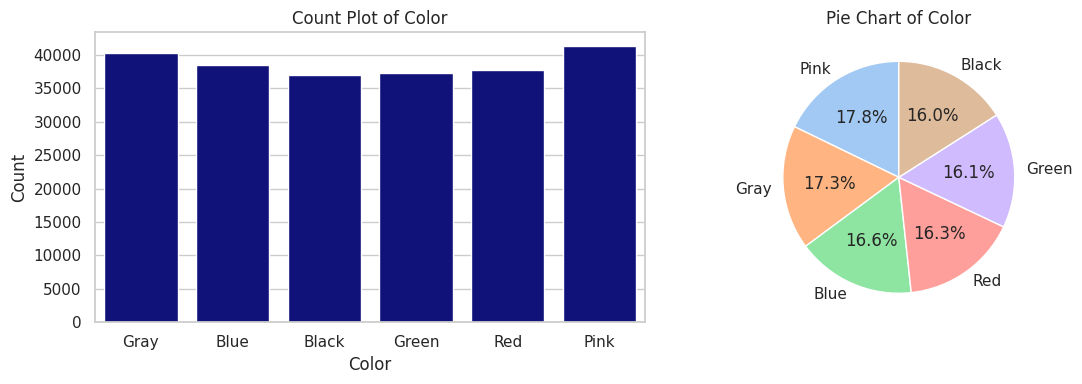

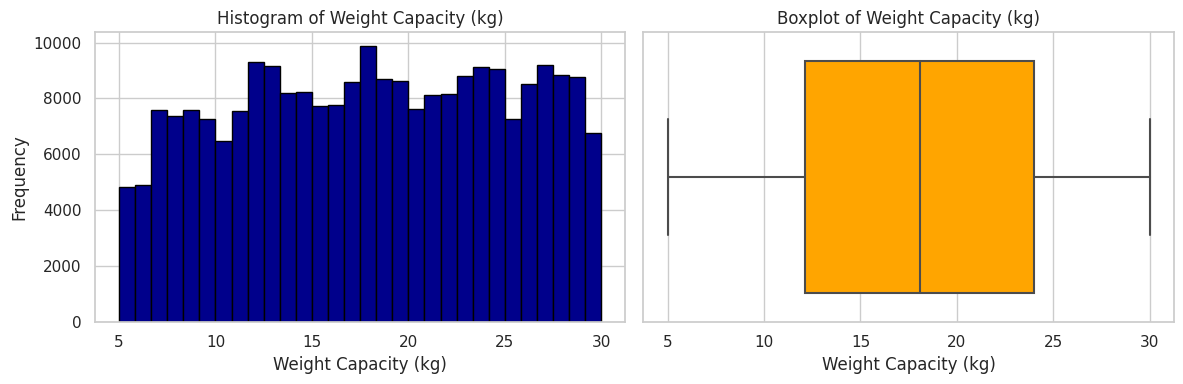

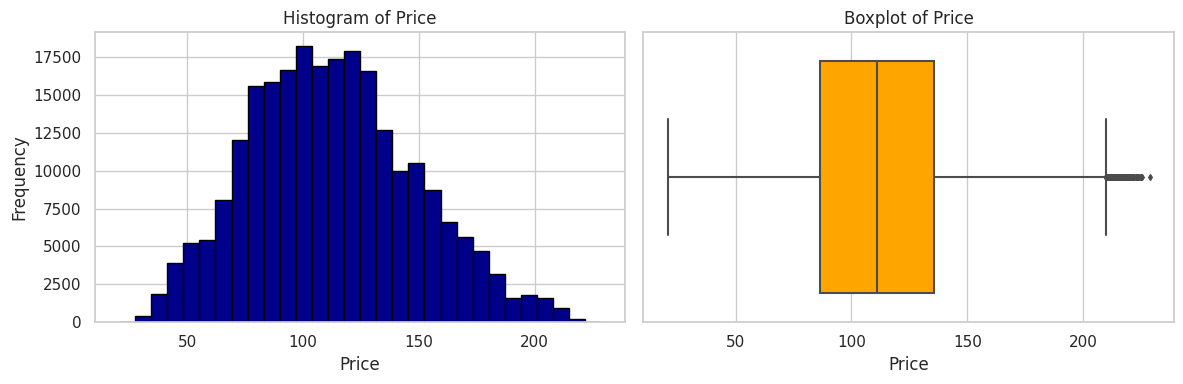

In [6]:
# Assuming train_data is your DataFrame and 'id' is one of its columns.
cols_to_plot = [col for col in train_data.columns if col != 'id']

# Set a style for consistency
sns.set(style="whitegrid")

for col in cols_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(train_data[col]):
        # Left subplot: Histogram (deep blue)
        axes[0].hist(train_data[col].dropna(), bins=30, color='darkblue', edgecolor='black')
        axes[0].set_title(f'Histogram of {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Frequency')

        # Right subplot: Boxplot (orange)
        sns.boxplot(x=train_data[col].dropna(), ax=axes[1],
                    color='orange', fliersize=3,
                    boxprops={'facecolor': 'orange'})
        axes[1].set_title(f'Boxplot of {col}')
        axes[1].set_xlabel(col)
    else:
        # For categorical variables:
        # Left subplot: Count plot (bar plot)
        sns.countplot(x=train_data[col], ax=axes[0], color='darkblue')
        axes[0].set_title(f'Count Plot of {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Count')

        # Right subplot: Pie chart
        value_counts = train_data[col].value_counts()
        axes[1].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%',
                    startangle=90, colors=sns.color_palette('pastel'))
        axes[1].set_title(f'Pie Chart of {col}')

    plt.tight_layout()
    plt.show()


##  Multivariate analysis

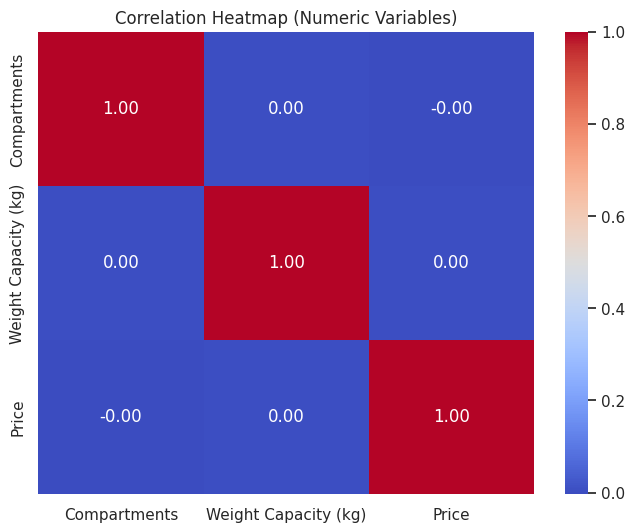

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


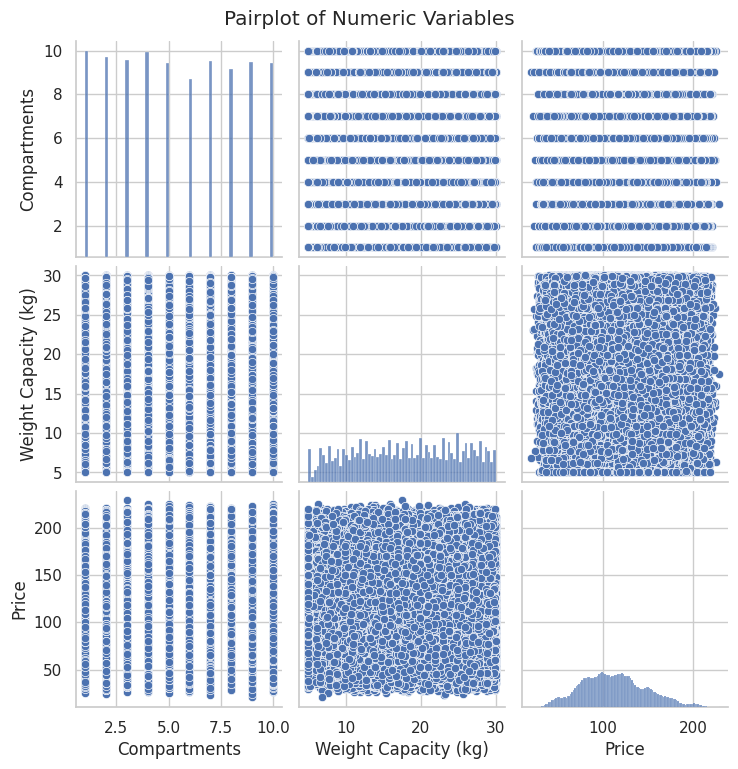

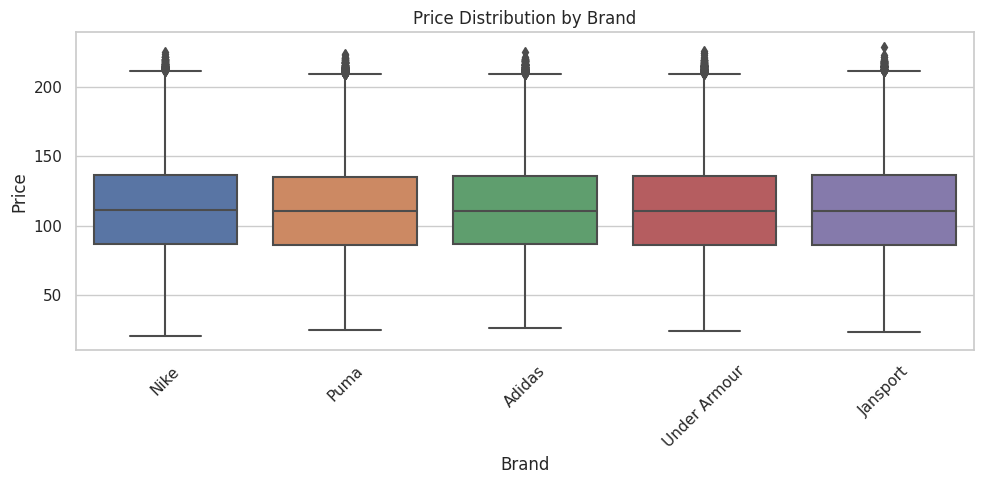

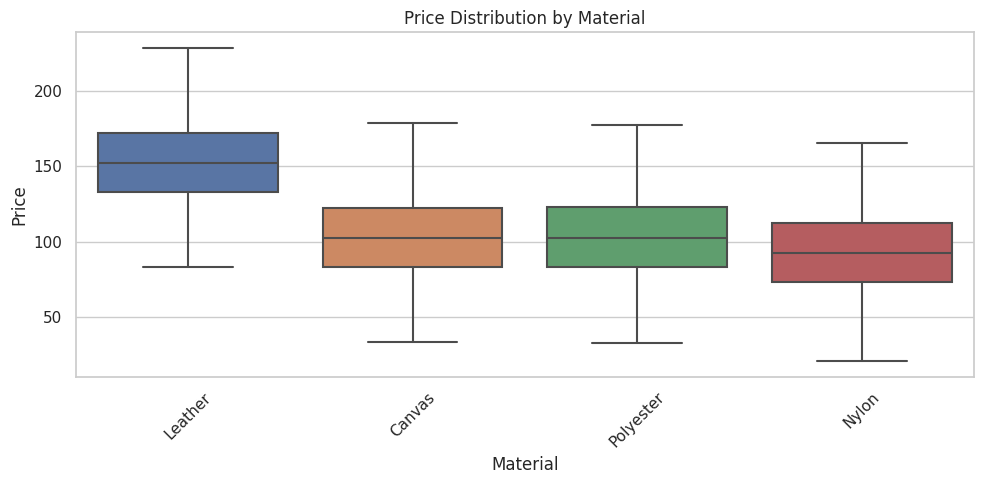

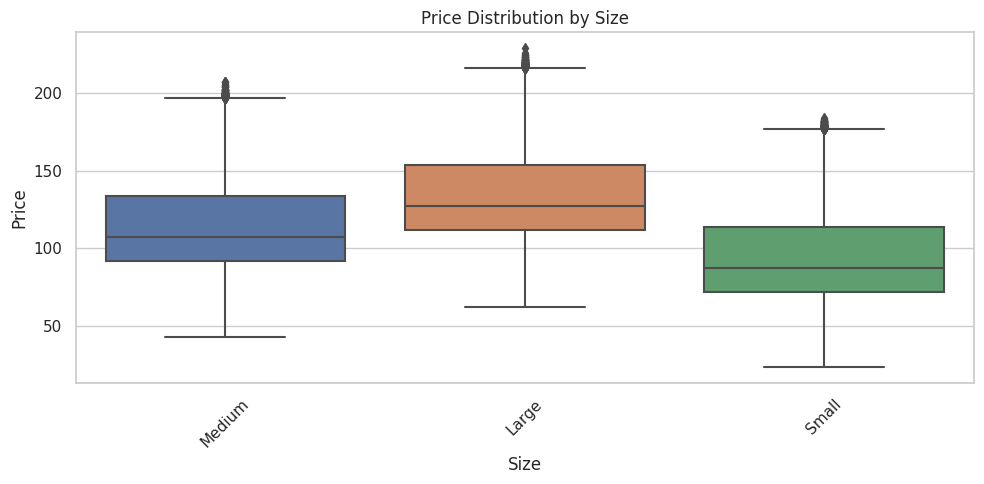

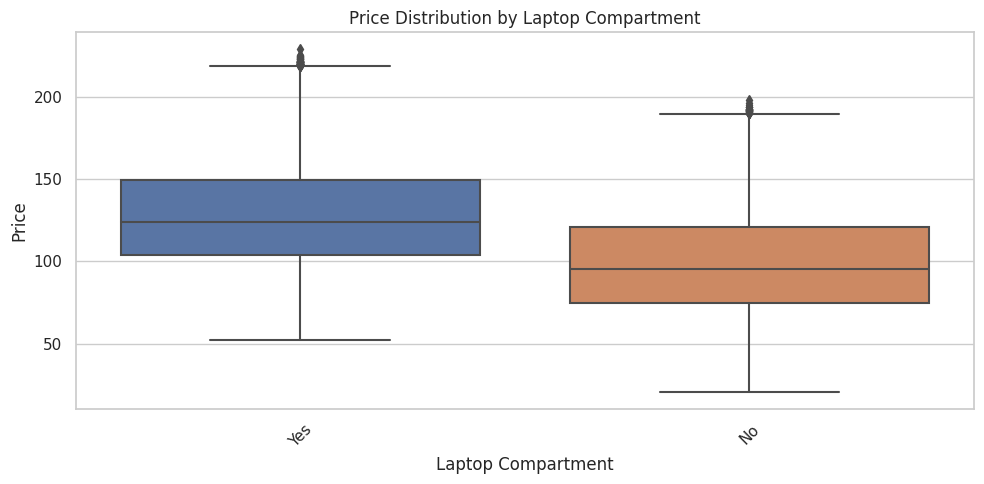

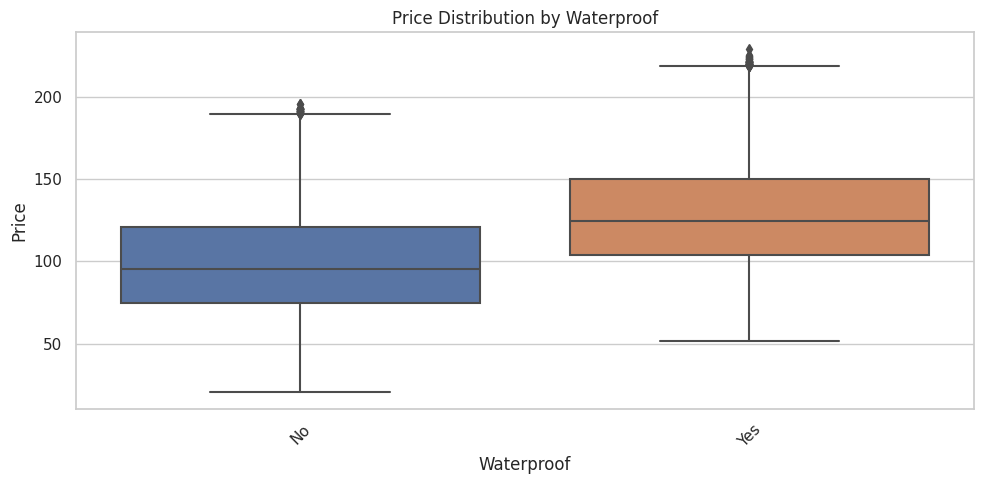

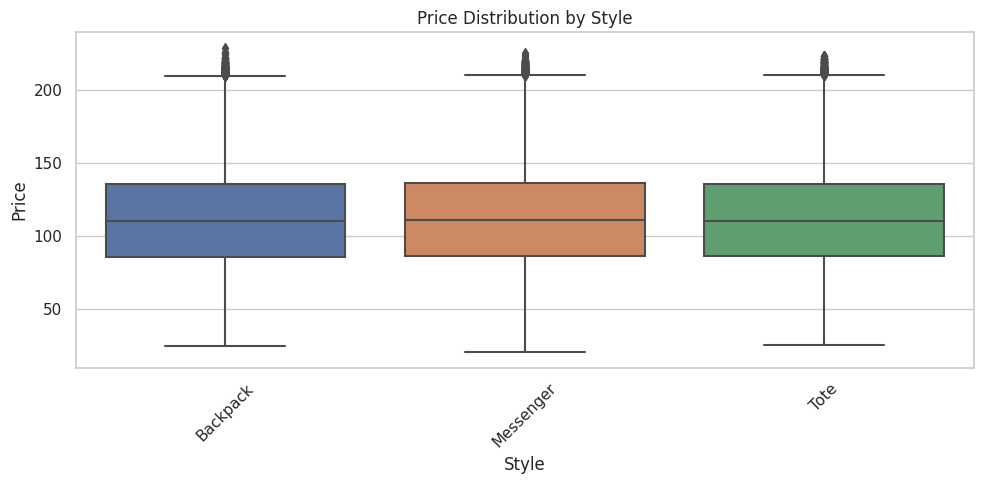

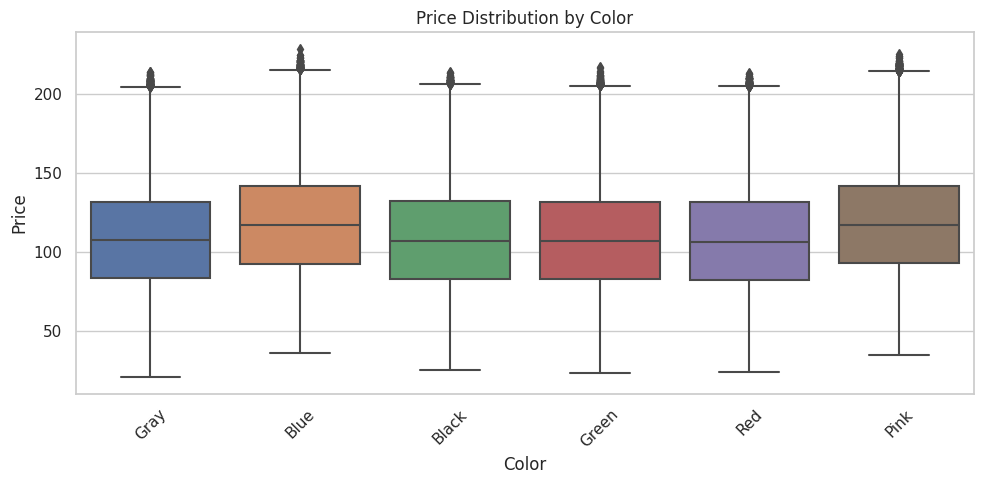

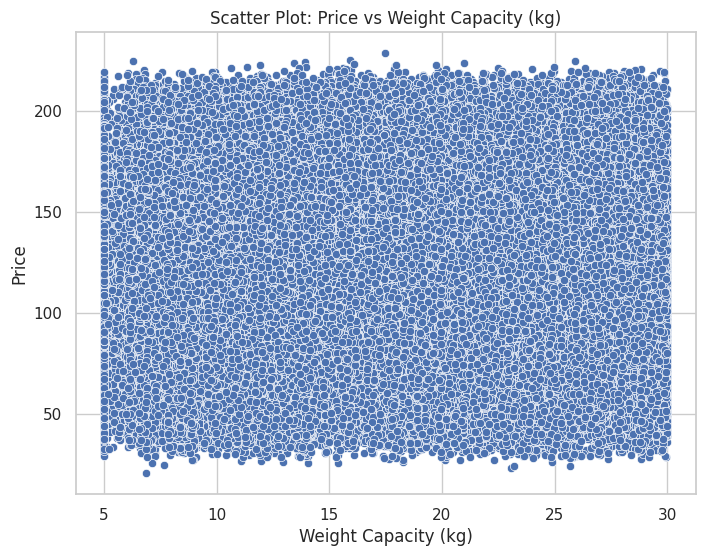

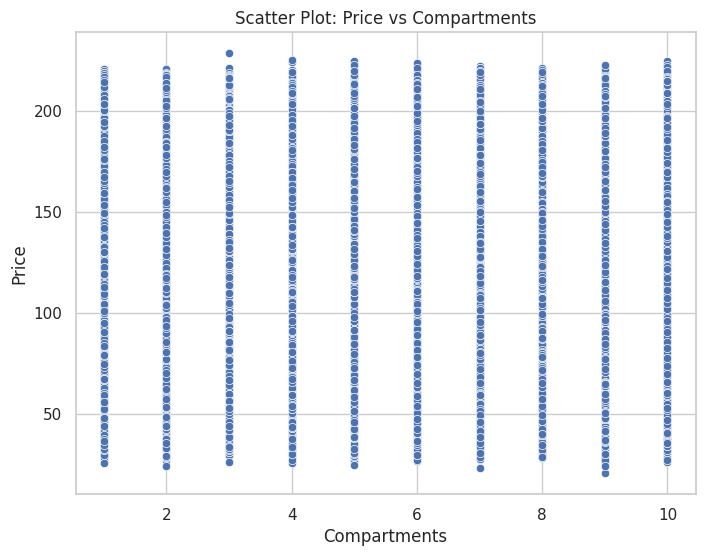

In [7]:
# Assuming train_data is already loaded in memory and is a pandas DataFrame
# and that the 'id' column should be ignored for our analysis.

# ----------------------------
# 1. Correlation Heatmap (Numeric Features)
# ----------------------------

# Select only numeric columns and drop 'id'
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'id' in numeric_cols:
    numeric_cols.remove('id')

# Compute the correlation matrix for numeric features
numeric_corr = train_data[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Variables)")
plt.show()

# ----------------------------
# 2. Pairplot of Numeric Variables
# ----------------------------
# This gives a quick multivariate look at the distributions and pairwise relationships
sns.pairplot(train_data[numeric_cols])
plt.suptitle("Pairplot of Numeric Variables", y=1.02)
plt.show()

# ----------------------------
# 3. Boxplots of Price by Categorical Variables
# ----------------------------
# Define the categorical columns (excluding id)
categorical_cols = ['Brand', 'Material', 'Size', 'Laptop Compartment',
                    'Waterproof', 'Style', 'Color']

# Loop over each categorical column and create a boxplot to see the impact on Price
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=train_data, x=col, y='Price')
    plt.title(f"Price Distribution by {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ----------------------------
# 4. Scatter Plots for Selected Numeric Relationships
# ----------------------------
# Scatter plot: Price vs Weight Capacity (kg) to inspect any linear association
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_data, x='Weight Capacity (kg)', y='Price')
plt.title("Scatter Plot: Price vs Weight Capacity (kg)")
plt.xlabel("Weight Capacity (kg)")
plt.ylabel("Price")
plt.show()

# Scatter plot: Price vs Compartments (if applicable)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_data, x='Compartments', y='Price')
plt.title("Scatter Plot: Price vs Compartments")
plt.xlabel("Compartments")
plt.ylabel("Price")
plt.show()

# XGBoost model

Train Data Head:


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
254099,254099,Nike,Leather,Medium,1.0,Yes,No,Backpack,Gray,27.294880,155.384628
53461,53461,Puma,NaN,Large,9.0,Yes,Yes,Messenger,Blue,8.574545,162.246230
247984,247984,Adidas,Canvas,Medium,8.0,Yes,No,Messenger,Black,11.502436,104.316043
209067,209067,Under Armour,Polyester,Medium,3.0,No,No,Backpack,Black,9.433317,69.857043
185997,185997,Puma,Nylon,Small,8.0,No,Yes,Backpack,Black,8.971236,77.047670



Test Data Head:


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
4941,4941,Jansport,Leather,Large,2.0,Yes,Yes,Tote,Blue,26.856190,208.971861
51775,51775,Puma,Canvas,Medium,3.0,No,No,Messenger,Pink,15.068683,92.330572
115253,115253,Jansport,Canvas,Small,2.0,Yes,No,Tote,Red,22.936807,84.901156
299321,299321,Under Armour,Polyester,Large,7.0,No,No,Messenger,Blue,11.917135,100.415763
173570,173570,Puma,Leather,Small,7.0,No,No,Tote,Gray,18.352518,108.288147


Test RMSE: 5.0312


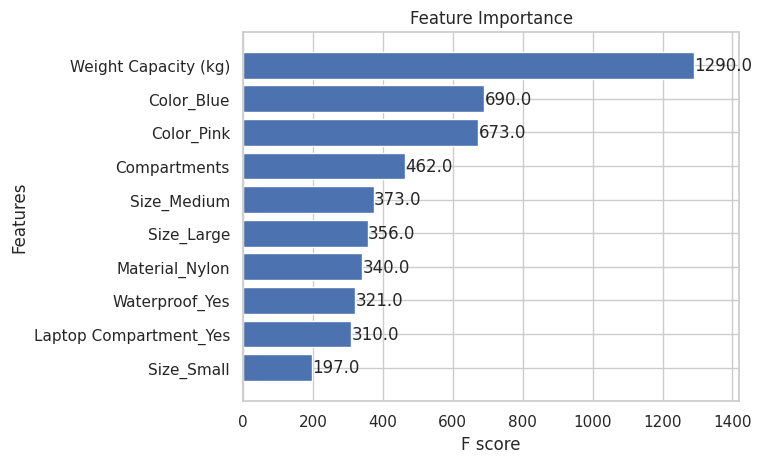

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# -------------------------------
# 1. Insect the Data
# -------------------------------

# Display the first few rows (as provided)
print("Train Data Head:")
display(train_data.head())
print("\nTest Data Head:")
display(test_data.head())

# -------------------------------
# 2. Preprocess the Data
# -------------------------------

# Drop the 'id' column from both datasets as it is not predictive
train = train_data.drop(['id'], axis=1)
test = test_data.drop(['id'], axis=1)

# Separate features and target
X_train = train.drop('Price', axis=1)
y_train = train['Price']
X_test = test.drop('Price', axis=1)
y_test = test['Price']

# Identify categorical columns.
# In this dataset, the following columns are categorical:
categorical_cols = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

# Convert categorical variables to dummy/indicator variables.
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Ensure that both train and test have the same dummy columns.
# This reindexes X_test to have the same columns as X_train, filling missing columns with 0.
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# -------------------------------
# 3. Build and Train the XGBoost Model
# -------------------------------
# Initialize the XGBRegressor.
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # regression with squared error
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Train the model on the training data.
model.fit(X_train, y_train)

# -------------------------------
# 4. Evaluate the Model
# -------------------------------
# Make predictions on the test set.
y_pred = model.predict(X_test)

# Calculate the RMSE on the test set.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

# -------------------------------
# 5. Plot Feature Importance
# -------------------------------
# XGBoost has a built-in plot_importance function.
ax = xgb.plot_importance(model, max_num_features=10, height=0.8)  # showing top 10 features
plt.title("Feature Importance")
plt.show()


# Constant sub

- See [The target is just noise?](https://www.kaggle.com/competitions/playground-series-s5e2/discussion/560669)

In [9]:
# ----------------------------
# Step 1: Load training data
# ----------------------------
train_df = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')

# ----------------------------
# Step 2: Compute the global mean of Price
# ----------------------------
global_mean = train_df['Price'].mean()
print(f"Global Mean of Price: {global_mean}")

# ----------------------------
# Step 3: Set up K-Fold Cross Validation
# ----------------------------
n_splits = 5  # You can change this if needed
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

cv_rmse_scores = []

# ----------------------------
# Step 4: Evaluate using constant prediction = global_mean
# ----------------------------
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df), 1):
    # Extract the true prices for the validation fold
    y_valid = train_df.loc[valid_idx, 'Price'].values

    # Make constant predictions using the global mean
    y_pred = np.full(shape=y_valid.shape, fill_value=global_mean)
    
    # Compute RMSE for the fold
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    cv_rmse_scores.append(rmse)
    
    print(f"Fold {fold}: RMSE = {rmse}")

# Compute and print the average CV RMSE
average_rmse = np.mean(cv_rmse_scores)
print(f"\nAverage CV RMSE: {average_rmse}")

# ----------------------------
# Step 5: Create submission file using constant prediction
# ----------------------------
# Load test data (assumed to have an 'id' column)
test_df = pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')

# Create the submission DataFrame: every Price is predicted as the global_mean
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'Price': global_mean
})

# Save the submission file (CSV format)
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"Submission file '{submission_filename}' created with {len(submission_df)} rows.")

Global Mean of Price: 81.41110683033334
Fold 1: RMSE = 38.94404061505901
Fold 2: RMSE = 39.07663041163538
Fold 3: RMSE = 39.03812811556618
Fold 4: RMSE = 39.1038251484333
Fold 5: RMSE = 39.03356443467629

Average CV RMSE: 39.03923774507403
Submission file 'submission.csv' created with 200000 rows.
